In [2]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Using device: cpu


In [3]:
# Update the path

GRIZZLY_ROOT = r"./GRIZZLY"
TABLE_A4_PATH = r"./Table_A4.xlsx"

PSD_DIR = os.path.join(GRIZZLY_ROOT, "particle-size")
WRC_DIR = os.path.join(GRIZZLY_ROOT, "water retention")

N_PSD = 50  
N_WRC = 50  

PSD_GRID = np.logspace(np.log10(2.0), np.log10(2000.0), N_PSD)  
WRC_GRID = np.logspace(np.log10(1.0), np.log10(40000.0), N_WRC) 

print(f"PSD grid: {N_PSD} points from {PSD_GRID[0]:.1f} to {PSD_GRID[-1]:.1f} μm")
print(f"WRC grid: {N_WRC} points from {WRC_GRID[0]:.1f} to {WRC_GRID[-1]:.1f} kPa")

PSD grid: 50 points from 2.0 to 2000.0 μm
WRC grid: 50 points from 1.0 to 40000.0 kPa


In [4]:
def load_table_a4(path: str) -> pd.DataFrame:
    raw = pd.read_excel(path)
    df = raw.iloc[2:].copy()
    df.columns = ["Soil", "OrganicMatter", "Porosity", "Clay", "Silt", "Sand"]
    
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    
    df = df.dropna(subset=["Soil"]).copy()
    df["Soil"] = df["Soil"].astype(int)
    df = df.set_index("Soil").sort_index()
    
    return df[["OrganicMatter", "Porosity", "Sand", "Silt", "Clay"]]


def read_two_col_txt(path: str):
    arr = np.loadtxt(path)
    return arr[:, 0].astype(float), arr[:, 1].astype(float)


def interp_on_logx(x, y, x_new):
    x, y = np.asarray(x), np.asarray(y)
    mask = x > 0
    x, y = x[mask], y[mask]
    
    idx = np.argsort(x)
    x, y = x[idx], y[idx]
 
    df = pd.DataFrame({"x": x, "y": y}).groupby("x", as_index=False).mean()
    x, y = df["x"].values, df["y"].values
 
    lx = np.log10(x)
    lx_new = np.log10(x_new)
    y_new = np.interp(lx_new, lx, y, left=y[0], right=y[-1])
    
    return y_new


def get_id_from_name(filename: str) -> int:
    return int(re.findall(r"\d+", filename)[0])


def load_sample(sample_id: int):
    psd_file = os.path.join(PSD_DIR, f"G{sample_id}.DAT")
    wrc_file = os.path.join(WRC_DIR, f"H{sample_id}.DAT")
    
    if not (os.path.exists(psd_file) and os.path.exists(wrc_file)):
        return None

    d, mf = read_two_col_txt(psd_file)
    psd_vec = interp_on_logx(d, mf, PSD_GRID)

    s, theta = read_two_col_txt(wrc_file)
    wrc_vec = interp_on_logx(s, theta, WRC_GRID)
    
    return psd_vec.astype(np.float32), wrc_vec.astype(np.float32)


print("Data loading functions defined.")

Data loading functions defined.


In [ ]:
props = load_table_a4(TABLE_A4_PATH)
print(f"Loaded soil properties: {props.shape}")
print(f"\nFirst few rows:\n{props.head()}")

psd_ids = {get_id_from_name(f) for f in os.listdir(PSD_DIR) if f.upper().endswith(".DAT")}
wrc_ids = {get_id_from_name(f) for f in os.listdir(WRC_DIR) if f.upper().endswith(".DAT")}
prop_ids = set(props.index.tolist())
common_ids = sorted(list(psd_ids & wrc_ids & prop_ids))

print(f"\nPSD files: {len(psd_ids)}")
print(f"WRC files: {len(wrc_ids)}")
print(f"Table_A4 rows: {len(prop_ids)}")
print(f"Usable samples: {len(common_ids)}")

X_list, Y_list, id_list = [], [], []
for sid in common_ids:
    loaded = load_sample(sid)
    if loaded is None:
        continue
    
    psd_vec, wrc_vec = loaded
    p = props.loc[sid].values.astype(np.float32)

    x = np.concatenate([psd_vec, p], axis=0) 
    X_list.append(x)
    Y_list.append(wrc_vec)
    id_list.append(sid)

X = np.stack(X_list) 
Y = np.stack(Y_list)  

print(f"\nFinal dataset shape: X={X.shape}, Y={Y.shape}")
print(f"Input features: {X.shape[1]} (PSD: {N_PSD}, Properties: 5)")
print(f"Output features: {Y.shape[1]} (WRC points)")

C:\Users\hbpra\AppData\Roaming\Python\Python314\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Super Source File screaned'!$A:$F.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


Loaded soil properties: (527, 5)

First few rows:
      OrganicMatter  Porosity       Sand       Silt       Clay
Soil                                                          
1               0.0     0.472  23.834602  36.219269  39.946129
2               0.0     0.442  38.480874  38.244930  23.274196
3               0.0     0.426  53.820671  35.608846  10.570483
4               0.0     0.453  34.715803  36.386997  28.897199
5               0.0     0.357  99.870426   0.129560   0.000015

PSD files: 660
WRC files: 660
Table_A4 rows: 527
Usable samples: 527

Final dataset shape: X=(527, 55), Y=(527, 50)
Input features: 55 (PSD: 50, Properties: 5)
Output features: 50 (WRC points)


: 

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=SEED
)

mu = X_train.mean(axis=0, keepdims=True)
sd = X_train.std(axis=0, keepdims=True) + 1e-8

X_train_s = (X_train - mu) / sd
X_test_s = (X_test - mu) / sd

print(f"Train set: {X_train_s.shape[0]} samples")
print(f"Test set:  {X_test_s.shape[0]} samples")
print(f"Split ratio: {X_train_s.shape[0] / X.shape[0]:.1%} train, {X_test_s.shape[0] / X.shape[0]:.1%} test")

Train set: 421 samples
Test set:  106 samples
Split ratio: 79.9% train, 20.1% test


In [6]:
class SoilDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]


class ImprovedMLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=(256, 256, 128), dropout=0.1, use_batch_norm=True):
        super().__init__()
        
        layers = []
        prev = in_dim
        
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = h
        
        layers.append(nn.Linear(prev, out_dim))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)


print("Model architecture defined.")

Model architecture defined.


In [7]:
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


def pearson_r2(y_true, y_pred):
    yt = y_true.reshape(-1)
    yp = y_pred.reshape(-1)
    yt = yt - yt.mean()
    yp = yp - yp.mean()
    r = (yt @ yp) / (np.sqrt((yt @ yt) * (yp @ yp)) + 1e-12)
    return float(r * r)


print("Evaluation metrics defined.")

Evaluation metrics defined.


In [8]:
def train_model(X_train, Y_train, X_val, Y_val, 
                hidden=(256, 256), lr=1e-3, weight_decay=1e-4,
                dropout=0.1, batch_size=64, epochs=300, patience=30,
                use_batch_norm=True, device=None, verbose=True):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    train_ds = SoilDataset(X_train, Y_train)
    val_ds = SoilDataset(X_val, Y_val)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
 
    model = ImprovedMLP(
        in_dim=X_train.shape[1], 
        out_dim=Y_train.shape[1], 
        hidden=hidden, 
        dropout=dropout,
        use_batch_norm=use_batch_norm
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
 
    best_state = None
    best_val_loss = float("inf")
    patience_counter = 0
    history = {"train_loss": [], "val_loss": [], "train_rmse": [], "val_rmse": []}
    
    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                val_losses.append(loss.item())

            train_pred = model(torch.tensor(X_train, dtype=torch.float32).to(device)).cpu().numpy()
            val_pred = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy()
        
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_rm = rmse(Y_train, train_pred)
        val_rm = rmse(Y_val, val_pred)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_rmse"].append(train_rm)
        history["val_rmse"].append(val_rm)

        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
        
        if verbose and epoch % 20 == 0:
            print(f"  Epoch {epoch:3d}: Train RMSE={train_rm:.5f}, Val RMSE={val_rm:.5f}")
        
        if patience_counter >= patience:
            if verbose:
                print(f"  Early stopping at epoch {epoch}")
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    
    return model, history


print("Training function defined.")

Training function defined.


In [9]:
X_tr, X_val, Y_tr, Y_val = train_test_split(
    X_train_s, Y_train, test_size=0.2, random_state=SEED
)

print(f"Hyperparameter tuning split:")
print(f"  Training: {X_tr.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")

search_space = {
    "hidden": [(128, 128), (256, 256), (256, 256, 128), (512, 256, 128)],
    "lr": [1e-4, 3e-4, 1e-3, 3e-3],
    "dropout": [0.0, 0.1, 0.2],
    "weight_decay": [0.0, 1e-4, 1e-3],
    "batch_size": [32, 64, 128],
    "use_batch_norm": [True, False]
}

print(f"\nSearch space defined with {len(search_space)} parameters")

Hyperparameter tuning split:
  Training: 336 samples
  Validation: 85 samples

Search space defined with 6 parameters


In [10]:
n_trials = 15
device = "cuda" if torch.cuda.is_available() else "cpu"

best_config, best_model, best_history = None, None, None
best_val_rmse = float("inf")
all_results = []

print(f"Starting hyperparameter search with {n_trials} trials...\n")

for trial in range(n_trials):
    config = {
        "hidden": random.choice(search_space["hidden"]),
        "lr": random.choice(search_space["lr"]),
        "dropout": random.choice(search_space["dropout"]),
        "weight_decay": random.choice(search_space["weight_decay"]),
        "batch_size": random.choice(search_space["batch_size"]),
        "use_batch_norm": random.choice(search_space["use_batch_norm"]),
        "epochs": 300,
        "patience": 30
    }
    
    print(f"Trial {trial + 1}/{n_trials}")
    print(f"  Config: hidden={config['hidden']}, lr={config['lr']}, "
          f"dropout={config['dropout']}, batch_size={config['batch_size']}")
    
    model, history = train_model(
        X_tr, Y_tr, X_val, Y_val,
        device=device,
        verbose=False,
        **config
    )
    
    val_rmse = min(history["val_rmse"])
    all_results.append({
        "config": config.copy(),
        "val_rmse": val_rmse,
        "history": history
    })
    
    print(f"  Best Val RMSE: {val_rmse:.5f}")
    
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_config = config
        best_model = model
        best_history = history
        print(f"  *** New best model! ***")
    print()

print(f"\n{'='*70}")
print(f"Best configuration found:")
print(f"  Val RMSE: {best_val_rmse:.5f}")
print(f"  Config: {best_config}")
print(f"{'='*70}")

Starting hyperparameter search with 15 trials...

Trial 1/15
  Config: hidden=(128, 128), lr=0.0001, dropout=0.2, batch_size=32
  Best Val RMSE: 0.03989
  *** New best model! ***

Trial 2/15
  Config: hidden=(256, 256), lr=0.0001, dropout=0.2, batch_size=128
  Best Val RMSE: 0.04561

Trial 3/15
  Config: hidden=(512, 256, 128), lr=0.0001, dropout=0.0, batch_size=32
  Best Val RMSE: 0.03491
  *** New best model! ***

Trial 4/15
  Config: hidden=(128, 128), lr=0.0003, dropout=0.2, batch_size=128
  Best Val RMSE: 0.03658

Trial 5/15
  Config: hidden=(256, 256), lr=0.003, dropout=0.2, batch_size=32
  Best Val RMSE: 0.03364
  *** New best model! ***

Trial 6/15
  Config: hidden=(512, 256, 128), lr=0.001, dropout=0.1, batch_size=32
  Best Val RMSE: 0.03463

Trial 7/15
  Config: hidden=(128, 128), lr=0.0001, dropout=0.1, batch_size=64
  Best Val RMSE: 0.03506

Trial 8/15
  Config: hidden=(256, 256, 128), lr=0.0001, dropout=0.2, batch_size=128
  Best Val RMSE: 0.03941

Trial 9/15
  Config: hid

In [11]:
perm = np.random.permutation(X_train_s.shape[0])
n_tr = int(0.9 * X_train_s.shape[0])
X_tr_final = X_train_s[perm[:n_tr]]
Y_tr_final = Y_train[perm[:n_tr]]
X_val_final = X_train_s[perm[n_tr:]]
Y_val_final = Y_train[perm[n_tr:]]

print("Training final model on full training set...\n")

final_model, final_history = train_model(
    X_tr_final, Y_tr_final, X_val_final, Y_val_final,
    **best_config, device=device, verbose=True
)

print("\nFinal model training complete!")

Training final model on full training set...

  Epoch  20: Train RMSE=0.03535, Val RMSE=0.04868
  Epoch  40: Train RMSE=0.03134, Val RMSE=0.04267
  Epoch  60: Train RMSE=0.03171, Val RMSE=0.04302
  Epoch  80: Train RMSE=0.02779, Val RMSE=0.03805
  Early stopping at epoch 96

Final model training complete!


In [12]:
final_model.eval()
with torch.no_grad():
    Y_train_pred = final_model(torch.tensor(X_train_s, dtype=torch.float32).to(device)).cpu().numpy()
    Y_test_pred = final_model(torch.tensor(X_test_s, dtype=torch.float32).to(device)).cpu().numpy()

train_rmse = rmse(Y_train, Y_train_pred)
test_rmse = rmse(Y_test, Y_test_pred)
train_r2 = pearson_r2(Y_train, Y_train_pred)
test_r2 = pearson_r2(Y_test, Y_test_pred)

print(f"\n{'='*70}")
print(f"FINAL EVALUATION RESULTS")
print(f"{'='*70}")
print(f"\nTRAIN  - RMSE: {train_rmse:.5f} | Pearson R²: {train_r2:.5f}")
print(f"TEST   - RMSE: {test_rmse:.5f}  | Pearson R²: {test_r2:.5f}")
print(f"\n{'='*70}")


FINAL EVALUATION RESULTS

TRAIN  - RMSE: 0.03135 | Pearson R²: 0.95352
TEST   - RMSE: 0.03807  | Pearson R²: 0.94001



In [13]:
def plot_scatter(y_true, y_pred, title, save_path=None):
    yt = y_true.reshape(-1)
    yp = y_pred.reshape(-1)
    
    mn = min(yt.min(), yp.min())
    mx = max(yt.max(), yp.max())
    
    plt.figure(figsize=(7, 7))
    plt.scatter(yt, yp, s=10, alpha=0.4, edgecolors='none')
    plt.plot([mn, mx], [mn, mx], 'r--', linewidth=2, label='1:1 line')
    plt.xlabel("Measured Water Content", fontsize=12)
    plt.ylabel("Estimated Water Content", fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_training_history(history, save_path=None):
    """Plot RMSE vs epochs."""
    plt.figure(figsize=(8, 5))
    plt.plot(history["train_rmse"], label="Train RMSE", linewidth=2)
    plt.plot(history["val_rmse"], label="Validation RMSE", linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("RMSE", fontsize=12)
    plt.title("RMSE vs Epochs", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


print("Visualization functions defined.")

Visualization functions defined.


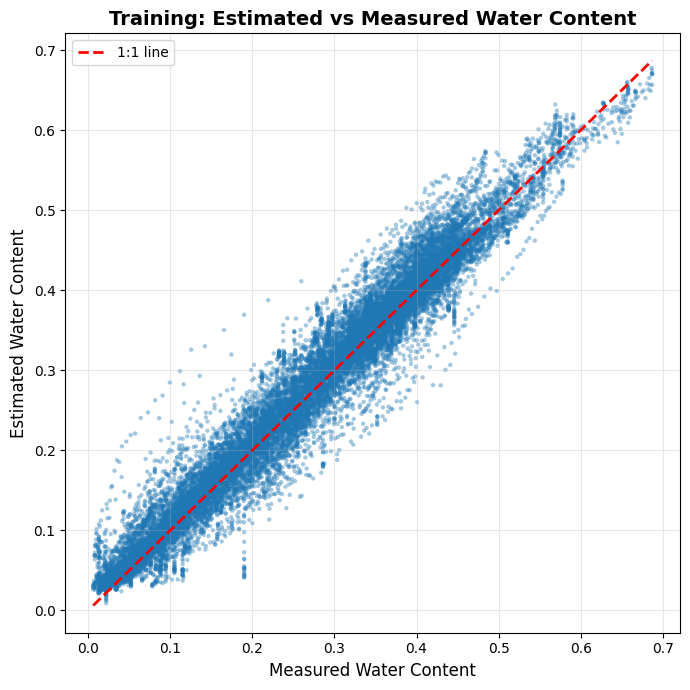

In [14]:
output_dir = Path("./outputs")
output_dir.mkdir(exist_ok=True)

plot_scatter(Y_train, Y_train_pred, 
            "Training: Estimated vs Measured Water Content",
            save_path=output_dir / "scatter_train.png")

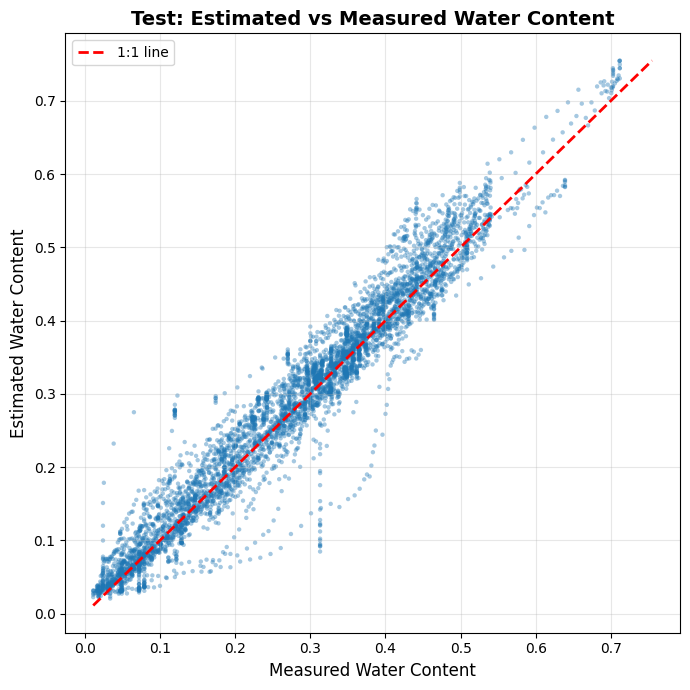

In [15]:
plot_scatter(Y_test, Y_test_pred,
            "Test: Estimated vs Measured Water Content",
            save_path=output_dir / "scatter_test.png")

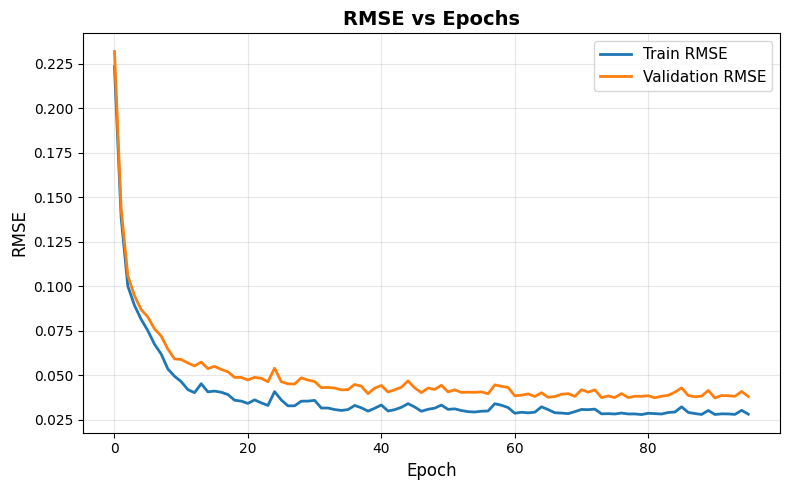

In [16]:
plot_training_history(final_history, 
                     save_path=output_dir / "training_history.png")

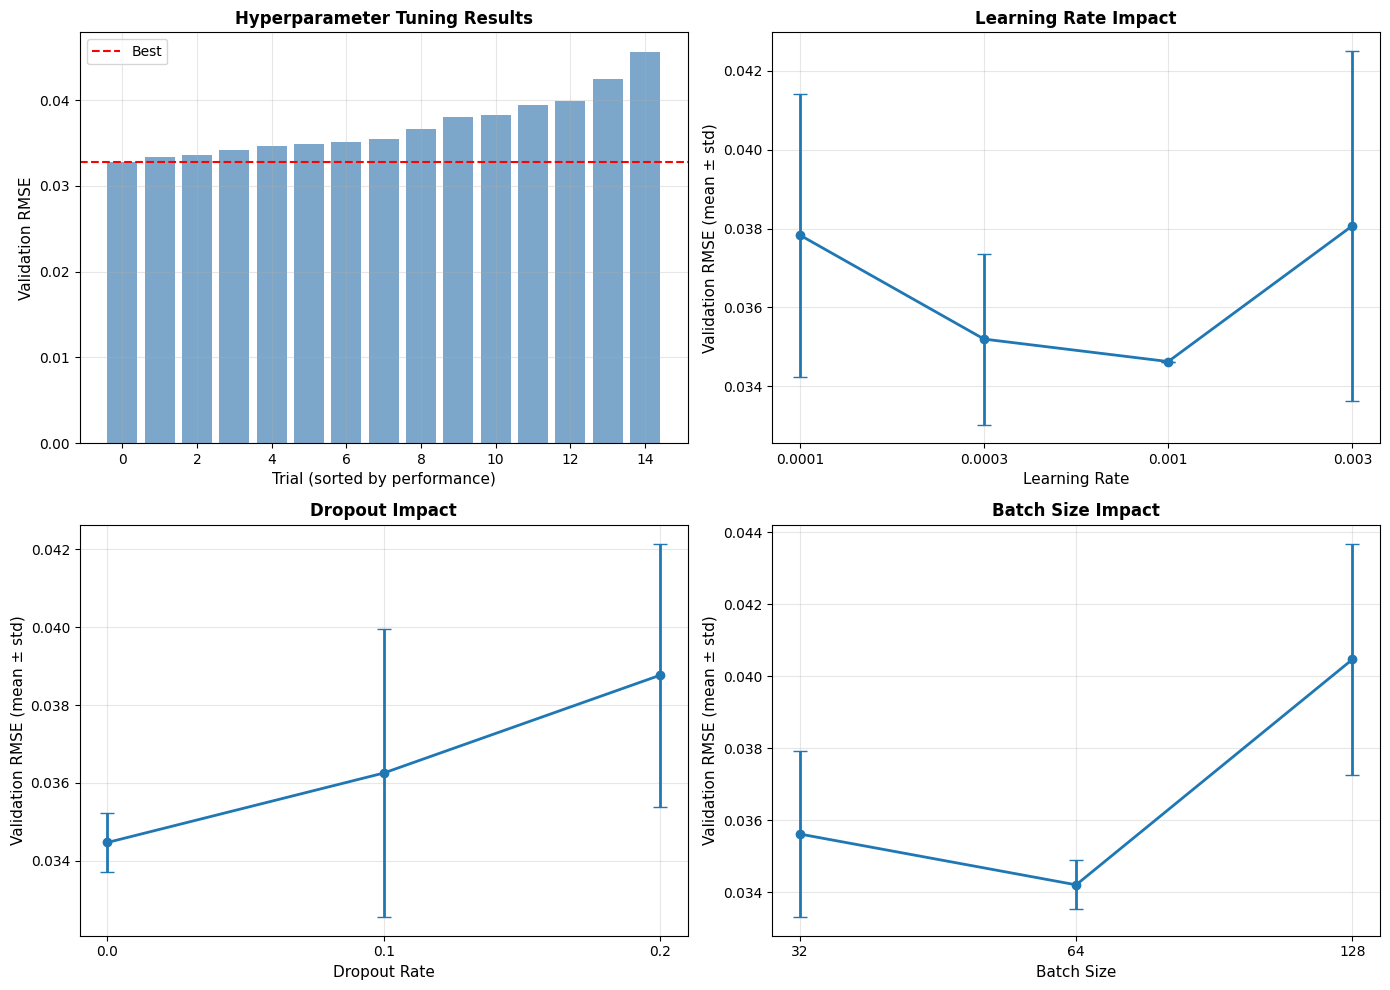

In [17]:
def plot_hyperparameter_results(all_results, save_path=None):
    configs = []
    val_rmses = []
    for res in all_results:
        configs.append(res["config"])
        val_rmses.append(res["val_rmse"])
    
    sorted_indices = np.argsort(val_rmses)
    sorted_rmses = np.array(val_rmses)[sorted_indices]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    ax = axes[0, 0]
    ax.bar(range(len(sorted_rmses)), sorted_rmses, color='steelblue', alpha=0.7)
    ax.axhline(y=sorted_rmses[0], color='r', linestyle='--', label='Best')
    ax.set_xlabel('Trial (sorted by performance)', fontsize=11)
    ax.set_ylabel('Validation RMSE', fontsize=11)
    ax.set_title('Hyperparameter Tuning Results', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[0, 1]
    lr_rmse = {}
    for cfg, rmse_val in zip(configs, val_rmses):
        lr = cfg["lr"]
        if lr not in lr_rmse:
            lr_rmse[lr] = []
        lr_rmse[lr].append(rmse_val)
    
    lrs = sorted(lr_rmse.keys())
    means = [np.mean(lr_rmse[lr]) for lr in lrs]
    stds = [np.std(lr_rmse[lr]) for lr in lrs]
    
    ax.errorbar([str(lr) for lr in lrs], means, yerr=stds, marker='o', capsize=5, linewidth=2)
    ax.set_xlabel('Learning Rate', fontsize=11)
    ax.set_ylabel('Validation RMSE (mean ± std)', fontsize=11)
    ax.set_title('Learning Rate Impact', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 0]
    dropout_rmse = {}
    for cfg, rmse_val in zip(configs, val_rmses):
        dropout = cfg["dropout"]
        if dropout not in dropout_rmse:
            dropout_rmse[dropout] = []
        dropout_rmse[dropout].append(rmse_val)
    
    dropouts = sorted(dropout_rmse.keys())
    means = [np.mean(dropout_rmse[d]) for d in dropouts]
    stds = [np.std(dropout_rmse[d]) for d in dropouts]
    
    ax.errorbar([str(d) for d in dropouts], means, yerr=stds, marker='o', capsize=5, linewidth=2)
    ax.set_xlabel('Dropout Rate', fontsize=11)
    ax.set_ylabel('Validation RMSE (mean ± std)', fontsize=11)
    ax.set_title('Dropout Impact', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 1]
    bs_rmse = {}
    for cfg, rmse_val in zip(configs, val_rmses):
        bs = cfg["batch_size"]
        if bs not in bs_rmse:
            bs_rmse[bs] = []
        bs_rmse[bs].append(rmse_val)
    
    batch_sizes = sorted(bs_rmse.keys())
    means = [np.mean(bs_rmse[bs]) for bs in batch_sizes]
    stds = [np.std(bs_rmse[bs]) for bs in batch_sizes]
    
    ax.errorbar([str(bs) for bs in batch_sizes], means, yerr=stds, marker='o', capsize=5, linewidth=2)
    ax.set_xlabel('Batch Size', fontsize=11)
    ax.set_ylabel('Validation RMSE (mean ± std)', fontsize=11)
    ax.set_title('Batch Size Impact', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


plot_hyperparameter_results(all_results,
                           save_path=output_dir / "hyperparameter_tuning.png")

Generating learning curve...
  Training with 50 samples...
    Test RMSE: 0.07857
  Training with 100 samples...
    Test RMSE: 0.22851
  Training with 150 samples...
    Test RMSE: 0.03902
  Training with 200 samples...
    Test RMSE: 0.04279
  Training with 300 samples...
    Test RMSE: 0.03881
  Training with 400 samples...
    Test RMSE: 0.03481
  Training with 421 samples...
    Test RMSE: 0.03846


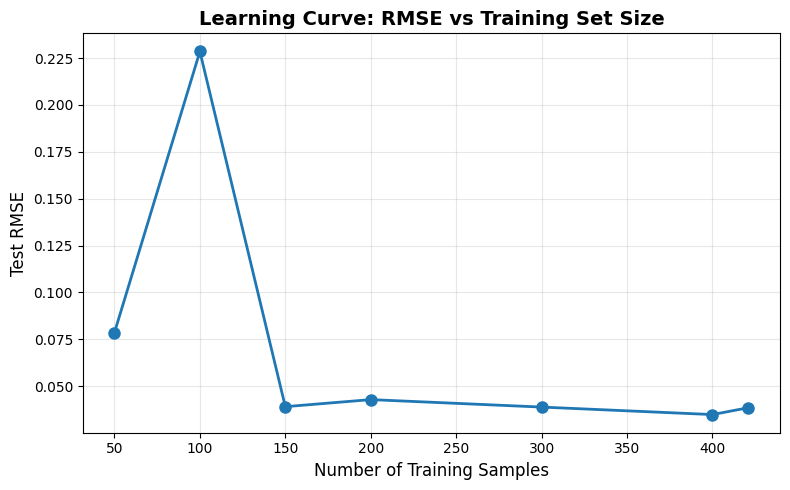

In [18]:
def plot_learning_curve(best_config, X_train_s, Y_train, X_test_s, Y_test, 
                        sizes=None, device=None, save_path=None):
    if sizes is None:
        max_size = X_train_s.shape[0]
        sizes = [50, 100, 150, 200, 300, 400, min(500, max_size), max_size]
        sizes = sorted(list(set([s for s in sizes if s <= max_size])))
    
    print("Generating learning curve...")
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    curve = []
    
    for n in sizes:
        print(f"  Training with {n} samples...")
        n = int(n)
        sub_idx = np.random.permutation(X_train_s.shape[0])[:n]
        X_sub, Y_sub = X_train_s[sub_idx], Y_train[sub_idx]

        perm = np.random.permutation(X_sub.shape[0])
        n_tr = max(10, int(0.9 * X_sub.shape[0]))
        X_tr, Y_tr = X_sub[perm[:n_tr]], Y_sub[perm[:n_tr]]
        X_va, Y_va = X_sub[perm[n_tr:]], Y_sub[perm[n_tr:]]
        
        model, _ = train_model(X_tr, Y_tr, X_va, Y_va, **best_config, 
                              device=device, verbose=False)
        
        model.eval()
        with torch.no_grad():
            y_pred = model(torch.tensor(X_test_s, dtype=torch.float32).to(device)).cpu().numpy()
        
        test_rmse = rmse(Y_test, y_pred)
        curve.append((n, test_rmse))
        print(f"    Test RMSE: {test_rmse:.5f}")
    
    curve = np.array(curve)
    
    plt.figure(figsize=(8, 5))
    plt.plot(curve[:, 0], curve[:, 1], marker='o', markersize=8, linewidth=2)
    plt.xlabel("Number of Training Samples", fontsize=12)
    plt.ylabel("Test RMSE", fontsize=12)
    plt.title("Learning Curve: RMSE vs Training Set Size", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return curve


learning_curve = plot_learning_curve(
    best_config, X_train_s, Y_train, X_test_s, Y_test,
    device=device, save_path=output_dir / "learning_curve.png"
)

In [19]:
torch.save({
    'model_state_dict': final_model.state_dict(),
    'config': best_config,
    'normalization': {'mu': mu, 'sd': sd},
    'train_rmse': train_rmse,
    'test_rmse': test_rmse,
    'train_r2': train_r2,
    'test_r2': test_r2
}, output_dir / "best_model.pth")
print(f"Model saved to: {output_dir / 'best_model.pth'}")

results_summary = {
    'train_rmse': train_rmse,
    'test_rmse': test_rmse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'best_config': str(best_config),
    'n_samples_train': len(Y_train),
    'n_samples_test': len(Y_test),
    'input_features': int(X.shape[1]),
    'output_features': int(Y.shape[1])
}

pd.DataFrame([results_summary]).to_csv(output_dir / "results_summary.csv", index=False)
print(f"Results saved to: {output_dir / 'results_summary.csv'}")

print("\n" + "="*70)
print("ALL OUTPUTS SAVED TO ./outputs/ DIRECTORY")
print("="*70)
print("\nGenerated files:")
print("  - scatter_train.png")
print("  - scatter_test.png")
print("  - training_history.png")
print("  - hyperparameter_tuning.png")
print("  - learning_curve.png")
print("  - best_model.pth")
print("  - results_summary.csv")

Model saved to: outputs\best_model.pth
Results saved to: outputs\results_summary.csv

ALL OUTPUTS SAVED TO ./outputs/ DIRECTORY

Generated files:
  - scatter_train.png
  - scatter_test.png
  - training_history.png
  - hyperparameter_tuning.png
  - learning_curve.png
  - best_model.pth
  - results_summary.csv
